Now we are using data from real malware samples.

Can we build a classifier for the polymorphic AllAple family?

In [1]:
import pandas as pd
from sklearn import svm
from sklearn import model_selection
from sklearn import metrics
import numpy as np
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

Experiment 1: Use the CLINICAL set of AllAple (these are verified AllAple samples)

Experiment 2: Use the COMPLETE set of AllAple (everything labeled AllAple on VirusTotal)

In [4]:
raw_data = pd.read_csv('total_complete.csv', index_col=None)

Split features and classes

In [5]:
learn_data = raw_data.copy()
classes = list(raw_data['class'])
del learn_data['class']

In [6]:
# lets standardize the data
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(learn_data)

Split data into a LEARN set and a TEST set. For the LEARN set we use 50% of the data; for the TEST set we use the remaining 50%

The TEST set helps to check how well our classifier would do on UNKNOWN data. It is a simulation.

Experiment 3: For the COMPLETE set, try different random states (like 0, 18) - what is the detection result?

In [7]:
train_features, test_features, train_classes, test_classes = \
model_selection.train_test_split(features_standardized, classes, test_size=0.2, random_state=0)

We use a Support Vector Classifier initially (then try other classifiers to see how the results change)

In [8]:
classifier = svm.SVC(gamma='auto')

Tell the classifier to learn based on TRAIN data

In [9]:
classifier.fit(train_features, train_classes)

SVC(gamma='auto')

Let's get the predictions for the TEST data

In [10]:
predicted_classes = classifier.predict(test_features)

Q: How good are the predictions?


In [11]:
attempts = 0
correct = 0
for i in range(len(predicted_classes)):
    predicted = predicted_classes[i]
    real_class = test_classes[i]
    if predicted == real_class:
        correct += 1
    attempts += 1
print('%d of %d trials correct: %f%%' % (correct, attempts, 100.0*correct/attempts))

83 of 97 trials correct: 85.567010%


In [12]:
print("Accuracy: %s" % (metrics.accuracy_score(test_classes, predicted_classes), ))
print(metrics.confusion_matrix(test_classes, predicted_classes))
print(classification_report(test_classes, predicted_classes, 
                            labels = np.unique(predicted_classes)))

Accuracy: 0.8556701030927835
[[22 14]
 [ 0 61]]
              precision    recall  f1-score   support

           0       1.00      0.61      0.76        36
           1       0.81      1.00      0.90        61

    accuracy                           0.86        97
   macro avg       0.91      0.81      0.83        97
weighted avg       0.88      0.86      0.85        97



##### Analysis of training size vs accuracy

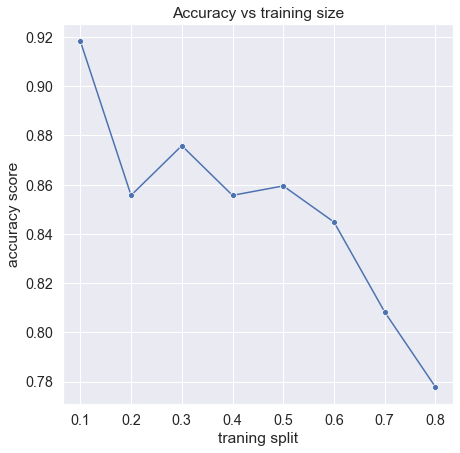

In [23]:
sizes = np.arange(.1,0.9,0.1)
results = []
for s in sizes:
    train_features, test_features, train_classes, test_classes = \
model_selection.train_test_split(features_standardized, classes, test_size=s, random_state=0)
    classifier = svm.SVC(gamma='auto')
    classifier.fit(train_features, train_classes)
    predicted_classes = classifier.predict(test_features)
    results.append(metrics.accuracy_score(test_classes, predicted_classes))
    
fig, ax = plt.subplots(figsize=(7, 7))
sns.set(font_scale=1.3)
sns.axes_style("darkgrid")
ax = sns.lineplot(x =sizes, y= results, marker='o')
ax.set_title('Accuracy vs training size')
ax.set_xlabel('traning split')
ax.set_ylabel('accuracy score')
plt.show()

    

In [18]:
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.svm import SVC


# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt.fit(train_features, train_classes)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(test_features, test_classes))
print("best params: %s" % str(opt.best_params_))

val. score: 0.9270833333333334
test score: 0.9431524547803618
best params: OrderedDict([('C', 109.93840915240972), ('degree', 5), ('gamma', 5.406371404971757), ('kernel', 'rbf')])


In [22]:
classifier = svm.SVC(C=109.9384,degree=5, gamma=5.406)
classifier.fit(train_features, train_classes)
predicted_classes = classifier.predict(test_features)
print(metrics.confusion_matrix(test_classes, predicted_classes))
print(classification_report(test_classes, predicted_classes))
print("Accuracy: %s" % (metrics.accuracy_score(test_classes, predicted_classes), ))

[[130  12]
 [ 10 235]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       142
           1       0.95      0.96      0.96       245

    accuracy                           0.94       387
   macro avg       0.94      0.94      0.94       387
weighted avg       0.94      0.94      0.94       387

Accuracy: 0.9431524547803618


In [39]:
# try LinearSVC classifier
classifier_lsvc = svm.LinearSVC(max_iter=5000)

# train the classifier with the train set
classifier_lsvc.fit(train_features, train_classes)

# get the score
classifier_lsvc.score(test_features, test_classes)

print(metrics.confusion_matrix(test_classes, predicted_classes))
print(classification_report(test_classes, predicted_classes, 
                            labels = np.unique(predicted_classes)))
print(classifier_lsvc.score(test_features, test_classes))

[[ 55  40]
 [  2 145]]
              precision    recall  f1-score   support

           0       0.96      0.58      0.72        95
           1       0.78      0.99      0.87       147

    accuracy                           0.83       242
   macro avg       0.87      0.78      0.80       242
weighted avg       0.85      0.83      0.81       242

0.8347107438016529


What does the Confusion Matrix say? Google/Wikipedia/...